<a href="https://colab.research.google.com/github/yoineko/skillfactory-module7/blob/master/car_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [ ]:
!pip install -q tensorflow==2.3

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 47kB/s 


In [ ]:
#аугментации изображений
!pip install albumentations -q

     |████████████████████████████████| 634kB 2.8MB/s 


In [ ]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/input'
PATH = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/'
WORK_PATH = "../working/" # рабочая директория

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from google.colab import drive
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import zipfile

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#для библиотеки albumentation
random.seed(RANDOM_SEED)

In [ ]:
# Текущая версия
ver = 24
# Текущий год + 1 
YEAR = 2021 

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
train = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_DIR,'sample_submission.csv'))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Пропуски присутствуют только в двух колонках Владельцы и Владение. В предобработке необходимо будет учесть это

In [ ]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [ ]:
# Подготовим для обработки поля  vehicleTransmission 
dir_transmissoin = {'автоматическая':' AT', 'вариатор':' CVT', 'механическая':' MT', 'роботизированная':' AMT'}

In [ ]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

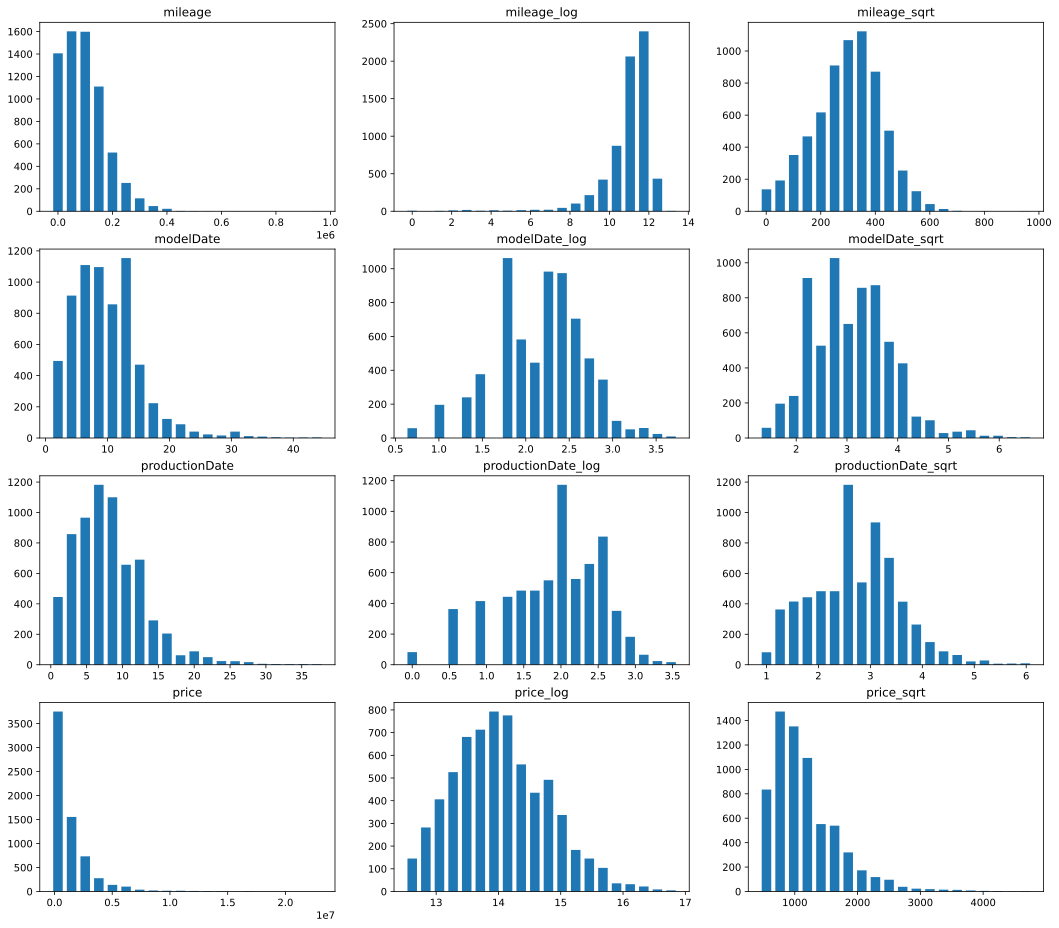

In [ ]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage':  train['mileage'],
    'mileage_log':  np.log(train['mileage']).dropna(),
    'mileage_sqrt':  np.sqrt(train['mileage']).dropna(),
    'modelDate':  YEAR - train['modelDate'],
    'modelDate_log':  np.log(YEAR - train['modelDate']).dropna(),
    'modelDate_sqrt':  np.sqrt(YEAR - train['modelDate']).dropna(),
    'productionDate':  YEAR - train['productionDate'],
    'productionDate_log':  np.log(YEAR - train['productionDate']).dropna(),
    'productionDate_sqrt':  np.sqrt(YEAR - train['productionDate']).dropna(),
    'price':  train['price'].dropna(),
    'price_log':  np.log(train['price']).dropna(),
    'price_sqrt':  np.sqrt(train['price']).dropna(),
})

Для обработки mileage лучше взять квадратный корень, а для остальных логарифм ( modelDate, productionDate), в том числе и для  price

In [ ]:
train.corr()

,mileage,modelDate,numberOfDoors,price,productionDate,sell_id,sample
mileage,1.000000,-0.679996,0.044090,-0.538860,-0.710065,-0.002886,NaN
modelDate,-0.679996,1.000000,0.095107,0.486031,0.963949,0.031029,NaN
numberOfDoors,0.044090,0.095107,1.000000,0.015021,0.108229,0.020418,NaN
price,-0.538860,0.486031,0.015021,1.000000,0.512432,0.024297,NaN
productionDate,-0.710065,0.963949,0.108229,0.512432,1.000000,0.035756,NaN
sell_id,-0.002886,0.031029,0.020418,0.024297,0.035756,1.000000,NaN
sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ModelDate коррелирует с productionDate , и его надо удалить из признаков, но эксперименты говорят об обратном( ухудшают результат на kaggle на 0.017 % 


# PreProc Tabular Data

In [ ]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', #'name','engineDisplacement', 'enginePower','Владение','ПТС','Руль',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы',  'Привод',  'xDrive']
  

#используем все числовые признаки, к ним добавим преобразованные
numerical_features = ['mileage', 'modelDate', 'productionDate']
numerical_features_all = numerical_features + ['enginePower_num','engineDisplacement_num','Владение_num','prod-model']

In [ ]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # код по обработке NAN
    df_output['Владельцы'].fillna('0', inplace=True)
    df_output['Владение'].fillna('-1', inplace=True)
    
    df_output['enginePower_num'] = df_output['enginePower'].apply(lambda x:x[:-4])
    df_output['engineDisplacement_num'] = df_output['engineDisplacement'].apply(lambda x:float(x[:-4]) if x != 'undefined LTR' else 0) 
    df_output['xDrive'] = df_output.apply(lambda x: x['name'].split(dir_transmissoin[x['vehicleTransmission']])[0].split(x['engineDisplacement'][:-4])[0], axis=1)
    


        ## 3. Столбец владение
    # Переведем значение поля Владение из текстового в численное - в количество месяцев владения
    def num_of_months(row):
        if row['Владение']!='-1':
            list_ownership = row['Владение'].split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
        else:
            if row['Владельцы'] == '3 или более':
                return (YEAR - row['productionDate'])*12/3
            elif row['Владельцы'] == '2 владельца':
                return (YEAR - row['productionDate'])*12/2
            else:
                return (YEAR - row['productionDate'])*12

    df_output['Владение_num'] = df_output.apply(num_of_months, axis=1)
    
    df_output['ПТС'] = df_output['ПТС'].map(lambda x:1 if x=='Оригинал' else 0 )
    df_output['Руль'] = df_output['Руль'].map(lambda x:1 if x=='Левый' else 0 )

    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей

        #корень пробега 
    df_output['mileage'] =  df_output['mileage'].map(lambda x: x**0.5)
    
    
    # Новые столбцы
        
    df_output['prod-model'] =df_output['modelDate'] - df_output['productionDate']
    df_output['modelDate'] = np.log(YEAR - df_output['modelDate'])
    df_output['productionDate'] = np.log(YEAR - df_output['productionDate'])

        # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features_all:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Clean #################################################### 
    # убираем признаки которые не будем обрабатывать 
    df_output.drop(['vehicleConfiguration','engineDisplacement','enginePower','name','Владение'], axis = 1, inplace=True)
    

    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,modelDate,productionDate,ПТС,Руль,sample,price,enginePower_num,engineDisplacement_num,Владение_num,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,...,xDrive_269,xDrive_270,xDrive_271,xDrive_272,xDrive_273,xDrive_274,xDrive_275,xDrive_276,xDrive_277,xDrive_278,xDrive_279,xDrive_280,xDrive_281,xDrive_282,xDrive_283,xDrive_284,xDrive_285,xDrive_286,xDrive_287,xDrive_288,xDrive_289,xDrive_290,xDrive_291,xDrive_292,xDrive_293,xDrive_294,xDrive_295,xDrive_296,xDrive_297,xDrive_298,xDrive_299,xDrive_300,xDrive_301,xDrive_302,xDrive_303,xDrive_304,xDrive_305,xDrive_306,xDrive_307,prod-model
7399,0.326435,0.389193,0.489076,1,1,1,1590000.0,0.2720,0.303030,0.126411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
4273,0.211343,0.430677,0.439310,1,1,1,3100000.0,0.2720,0.303030,0.065463,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
3362,0.233755,0.430677,0.489076,1,1,1,3750000.0,0.8160,0.833333,0.051919,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
2794,0.352906,0.500000,0.628510,1,1,1,1990000.0,0.2720,0.454545,0.088036,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
5378,0.385391,0.430677,0.489076,1,1,1,1285000.0,0.2288,0.303030,0.051919,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
5902,0.263460,0.467268,0.567601,1,1,1,3399999.0,0.7760,0.606061,0.214447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
1454,0.228937,0.467268,0.489076,1,1,0,0.0,0.3920,0.454545,0.079007,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
2476,0.415949,0.604531,0.700125,0,1,1,700000.0,0.2288,0.378788,0.092551,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
743,0.345756,0.604531,0.654526,1,1,0,0.0,0.0640,0.242424,0.097065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
1168,0.188926,0.467268,0.531153,1,1,0,0.0,0.7504,0.833333,0.060948,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889


In [ ]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 496 entries, mileage to prod-model
dtypes: float64(8), int64(3), uint8(485)
memory usage: 4.6 MB


## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет

X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 495 entries, mileage to prod-model
dtypes: float64(8), int64(2), uint8(485)
memory usage: 935.0 KB


# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
#Возьмем логарифм от целевого значения
y_train_f = np.log(y_train)
y_test_f  = np.log(y_test)

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.06,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train_f,
         eval_set=(X_test, y_test_f),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0405592	test: 0.0405938	best: 0.0405938 (0)	total: 50.6ms	remaining: 4m 12s
100:	learn: 0.0100896	test: 0.0099082	best: 0.0099071 (99)	total: 420ms	remaining: 20.4s
200:	learn: 0.0089854	test: 0.0090758	best: 0.0090758 (200)	total: 846ms	remaining: 20.2s
300:	learn: 0.0083306	test: 0.0086394	best: 0.0086394 (300)	total: 1.21s	remaining: 18.8s
400:	learn: 0.0078587	test: 0.0083293	best: 0.0083293 (400)	total: 1.58s	remaining: 18.1s
500:	learn: 0.0075454	test: 0.0081563	best: 0.0081557 (498)	total: 1.93s	remaining: 17.3s
600:	learn: 0.0072820	test: 0.0080234	best: 0.0080234 (600)	total: 2.29s	remaining: 16.8s
700:	learn: 0.0070733	test: 0.0079427	best: 0.0079422 (698)	total: 2.65s	remaining: 16.3s
800:	learn: 0.0068976	test: 0.0078816	best: 0.0078811 (799)	total: 3.02s	remaining: 15.8s
900:	learn: 0.0067511	test: 0.0078378	best: 0.0078365 (898)	total: 3.38s	remaining: 15.4s
1000:	learn: 0.0065731	test: 0.0077863	best: 0.0077845 (997)	total: 3.75s	remaining: 15s
1100:	learn: 0

In [ ]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST mape round: {(mape(y_test, test_predict_catboost.round(-3)))*100:0.2f}%")
test_predict_catboost1 = np.exp(model.predict(X))
print(f"TEST mape all: {(mape(y, test_predict_catboost1))*100:0.2f}%")

TEST mape: 11.11%
TEST mape round: 11.11%
TEST mape all: 8.35%


In [ ]:
# Сделаем предсказание на 10 фолдах
ITERATIONS =5000
LR = 0.06
N_FOLDS = 10

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              custom_metric=['RMSE', 'MAE'],
                              #depth =10,
                              random_seed = RANDOM_SEED,
                             # od_type='Iter',
                              od_wait =500,
                              )

    model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=False
         )    
    return(model)

In [ ]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test_true = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    yf_train = np.log(yf_train)
    yf_test =np.log(yf_test_true)
    # model for this fold
    model = cat_model(yf_train, Xf_train, Xf_test, yf_test,)
    # score model on test
    test_predict_catboostf = np.exp(model.predict(Xf_test)).round(-3)
    test_score = mape(yf_test_true, test_predict_catboostf)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test_true, test_predict_catboostf):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(X_sub))
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.5f}')
print(f'Std Score: {np.std(score_ls):0.5f}')
print(f'Max Score: {np.max(score_ls):0.5f}')
print(f'Min Score: {np.min(score_ls):0.5f}')

0:	learn: 0.0405507	test: 0.0412668	best: 0.0412668 (0)	total: 4.2ms	remaining: 21s
100:	learn: 0.0101053	test: 0.0097644	best: 0.0097644 (100)	total: 377ms	remaining: 18.3s
200:	learn: 0.0090565	test: 0.0089293	best: 0.0089293 (199)	total: 741ms	remaining: 17.7s
300:	learn: 0.0084058	test: 0.0084469	best: 0.0084469 (300)	total: 1.11s	remaining: 17.3s
400:	learn: 0.0079423	test: 0.0081491	best: 0.0081491 (400)	total: 1.48s	remaining: 16.9s
500:	learn: 0.0076174	test: 0.0079662	best: 0.0079662 (500)	total: 1.84s	remaining: 16.6s
600:	learn: 0.0073705	test: 0.0078392	best: 0.0078385 (597)	total: 2.21s	remaining: 16.1s
700:	learn: 0.0071615	test: 0.0077576	best: 0.0077576 (700)	total: 2.57s	remaining: 15.8s
800:	learn: 0.0069735	test: 0.0077043	best: 0.0077011 (796)	total: 2.95s	remaining: 15.5s
900:	learn: 0.0068164	test: 0.0076304	best: 0.0076304 (900)	total: 3.32s	remaining: 15.1s
1000:	learn: 0.0066732	test: 0.0075847	best: 0.0075846 (999)	total: 3.69s	remaining: 14.7s
1100:	learn: 0.

In [ ]:
test_predict_catboost_f= model.predict(X)
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST mape: {(mape(y, np.exp(test_predict_catboost_f)))*100:0.4f}%")
print(f"TEST mape: {(mape(y, np.exp(test_predict_catboost_f).round(-4)))*100:0.4f}%")

TEST mape: 6.84%
TEST mape: 7.6791%
TEST mape: 7.6870%


Среднее MAPE на фолдах 11.48%, это хуже, чем показатель у модели без фолдов 11.11%, но на всем множестве Х показатель лучше 7.68% против 8.35% Поэтому в бленде будем использователь предсказание на фолдах
 

### Submission

In [ ]:
#sub_predict_catboost = model.predict(X_sub)
#sub_predict_catboost = np.exp(model.predict(X_sub))

sub_predict_catboost = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(os.path.join(PATH,'submission',f'catboost_submission{ver}.csv'), index=False)
sub_predict_catboost 

0       7.577023e+05
1       2.663144e+06
2       6.243236e+05
3       4.944382e+05
4       2.675637e+06
            ...     
1666    1.074073e+06
1667    2.652811e+06
1668    1.518271e+06
1669    1.126643e+06
1670    1.046082e+06
Length: 1671, dtype: float64

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

,mileage,modelDate,productionDate,ПТС,Руль,enginePower_num,engineDisplacement_num,Владение_num,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,...,xDrive_269,xDrive_270,xDrive_271,xDrive_272,xDrive_273,xDrive_274,xDrive_275,xDrive_276,xDrive_277,xDrive_278,xDrive_279,xDrive_280,xDrive_281,xDrive_282,xDrive_283,xDrive_284,xDrive_285,xDrive_286,xDrive_287,xDrive_288,xDrive_289,xDrive_290,xDrive_291,xDrive_292,xDrive_293,xDrive_294,xDrive_295,xDrive_296,xDrive_297,xDrive_298,xDrive_299,xDrive_300,xDrive_301,xDrive_302,xDrive_303,xDrive_304,xDrive_305,xDrive_306,xDrive_307,prod-model
7320,0.386685,0.581508,0.628510,1,1,0.7504,0.909091,0.250564,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
8037,0.143857,0.284662,0.299875,1,1,0.2720,0.303030,0.079007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
4681,0.365285,0.664849,0.739185,1,1,0.2880,0.469697,0.133183,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
6014,0.574030,0.625965,0.720353,1,1,0.1744,0.272727,0.176072,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
3649,0.354319,0.500000,0.567601,1,1,0.3808,0.454545,0.173815,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889


## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               253440    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 385,025
Trainable params: 385,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5') , monitor='val_MAPE', verbose=1  , mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=150, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
 1/12 [=>............................] - ETA: 0s - loss: 46.1335 - MAPE: 46.1335
Epoch 00001: val_MAPE improved from inf to 46.08598, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 0s 26ms/step - loss: 47.0853 - MAPE: 47.0853 - val_loss: 46.0860 - val_MAPE: 46.0860
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 45.0862 - MAPE: 45.0862
Epoch 00002: val_MAPE improved from 46.08598 to 44.69790, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 45.8441 - MAPE: 45.8441 - val_loss: 44.6979 - val_MAPE: 44.6979
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 44.3371 - MAPE: 44.3371
Epoch 00003: val_MAPE improved from 44.69790 to 43.37962, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/b

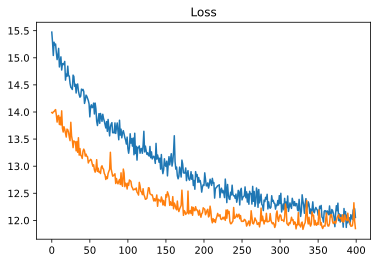

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'][100:], label='train')
plt.plot(history.history['val_MAPE'][100:], label='test')
plt.show();

In [ ]:
model.load_weights(os.path.join(PATH,'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_1_{ver}.hdf5'))

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test_true, np.exp(test_predict_nn1[:,0]).round(-3)))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test_true, np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 11.84%


В итоге имеем близкий результат к catboost, но чуть хуже. Добавление новых слоев в сети или уменьшение LR, не улучшают результат. Переобучения нет, но доубочение не дает эффекта

In [ ]:
sub_predict_nn1 = model.predict(X_sub)

sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn1_submission_{ver}.csv'), index=False)
sub_predict_nn1

array([[ 619809.7 ],
       [2650386.8 ],
       [ 616859.06],
       ...,
       [1498777.9 ],
       [1128983.9 ],
       [1028931.56]], dtype=float32)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [ ]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
!pip install pymorphy2
# библиотека для выделения лексем
import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk import everygrams

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 8.0MB 6.3MB/s 


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words_eng = set(stopwords.words("english"))
stop_words_rus = set(stopwords.words("russian"))

# Определим список стоп-слов, для исключениях их из описаний
stop_words = stop_words_eng | stop_words_rus

morph = pymorphy2.MorphAnalyzer()

#В description есть описания салонов продаж автомобилей, заменим их либо полностью на название салона(ключ - all), 
# либо частично(ключ - part)  
dict_text_replace ={('Более 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ','all') :'клиент РОЛЬФ',
                    ('Внимание! Только для клиентов AVILON','all'):'клиент AVILON' #}
                    ,('«Inchcape Certified-  Первый международный официальный гипермаркет автомобилей с пробегом и\nОфициальный дилер BMW,Mini, Land Rover, Jaguar, Toyota, Lexus, Mitsubishi, Hyundai, Volvo и Infiniti\nУникальные условия покупки автомобиля с пробегом в Inchcape Certified:\n-При обмене на Ваш автомобиль и покупке в кредит от 10,9%. Одобрение в течении 1 час по двум документам.\n-Выгодные условия выкупа вашего автомобиля. Получение 100% суммы из кассы в течение 1часа!\n-Автомобиль полностью проверен по технической и кузовной части, критических недостатков не выявлено.\n-Успешно пройдена криминалистическая проверка. Гарантия юридической чистоты.\n\n','part'):
                     'клиент Inchcape '}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Предобработка description
def pred_nlp(text):
 #      global list_grams
       # Удаление общих фраз
       for find_text, replace_text in dict_text_replace.items():
           if text.find(find_text[0])>-1:
              if find_text[1] == 'all':
                    text = replace_text
              else:
                    text = text.replace(find_text[0], replace_text) 
   #разбить на предложения
       text_by_sentence = nltk.sent_tokenize(text, language="russian")
       new_text = ''
       for sentences in text_by_sentence:
    #если "не" пишется различно , напишем слитно, чтобы смысл не потерять
           sentences = re.sub(r'не\s+', r'не', sentences)
    #убрать лишние символы, пробелы между разрядами в числах 
           sentences = re.sub('\n', ' ', sentences)
           sentences = re.sub(r'(\d)\s+(\d)', r'\1\2', sentences)
           pattern = r"[^\w]"
           sentences = re.sub(pattern, " ", sentences)
   #разбить на слова
           words =  nltk.word_tokenize(sentences.lower())
   #сделать лемматизацию
           words_morph = [morph.parse(word)[0].normal_form for word in words] 
   #убрать стоп слова
           without_stop_words = [word for word in words_morph if not word in stop_words]
           new_text = new_text + ' '.join(without_stop_words) +'. '

 #          list_grams +=[' '.join(list(para)) for para in everygrams(without_stop_words, 2, 2)]
       return new_text

In [ ]:
%%time
#list_grams = []
data['clear_description'] = data.description.map(pred_nlp)

CPU times: user 3min 21s, sys: 0 ns, total: 3min 21s
Wall time: 3min 21s


In [ ]:
# df_most = pd.DataFrame(col_grams.most_common(),columns=['text','counts'])
# df_most['count_words'] = df_most.text.map(lambda x:x.count(" "))
# df_most['new_word'] = df_most.text.map(lambda x:x.replace(" ",""))

# df_most[df_most.counts>50].sort_values(['counts','count_words'], ascending=[False,True])
# df_most[df_most.counts>200].sort_values(['text','count_words'], ascending=[True,True])

In [ ]:
# split данных
# text_train = data.description.iloc[X_train.index].map(lambda desc:re.sub('\n',' ',desc))
# text_test = data.description.iloc[X_test.index].map(lambda desc:re.sub('\n',' ',desc))
# text_sub = data.description.iloc[X_sub.index].map(lambda desc:re.sub('\n',' ',desc))

In [246]:
# split данных
text_train = data.clear_description.iloc[X_train.index]
text_test = data.clear_description.iloc[X_test.index]
text_sub = data.clear_description.iloc[X_sub.index]
text_all = data.clear_description.iloc[X.index]

### Tokenizer

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
#tokenize.fit_on_texts(data.clear_description.map(lambda desc:re.sub('\n',' ',desc)))
tokenize.fit_on_texts(data.clear_description)

CPU times: user 999 ms, sys: 0 ns, total: 999 ms
Wall time: 998 ms


In [ ]:
#tokenize.word_index

In [247]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

text_all_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_all), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[8])
print(text_train_sequences[8])

клиент inchcape отличный автомобиль. комплектация luxary особый условие представить автомобиль покупка кредит обмен комплектация 530i xdrive luxury антиблокировочный система система курсовой устойчивость датчик давление шина подушка безопасность водитель подушка безопасность пассажир боковой передний подушка безопасность оконный шторка безопасность система крепление детский автокресло isofix latch иммобилайзер центральный замок бортовый компьютер круиз контроль парктроника передний задний система автоматический парковка система помощь старт гора датчик свет датчик дождь активный усилитель руль запуск двигатель кнопка система старт стоп регулировка руль электрорегулировка сидение пассажир электростеклоподъемник передний задний электропривод зеркало климат контроль 1 зонный вентиляция сидение водитель пассажир подогрев сидение водитель пассажир подогрев руль обогрев зеркало обогрев форсунка стеклоомыватель навигационный система cd usb bluetooth aux hi fi мультифункциональный рулевой коле

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     6508288     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01) #0.01
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 99.9803 - MAPE: 99.9803
Epoch 00001: val_MAPE improved from inf to 99.77524, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 4s 353ms/step - loss: 99.9803 - MAPE: 99.9803 - val_loss: 99.7752 - val_MAPE: 99.7752
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 98.0788 - MAPE: 98.0788
Epoch 00002: val_MAPE improved from 99.77524 to 91.50232, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 3s 256ms/step - loss: 98.0788 - MAPE: 98.0788 - val_loss: 91.5023 - val_MAPE: 91.5023
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 74.0539 - MAPE: 74.0539
Epoch 00003: val_MAPE improved from 91.50232 to 50.68345, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working

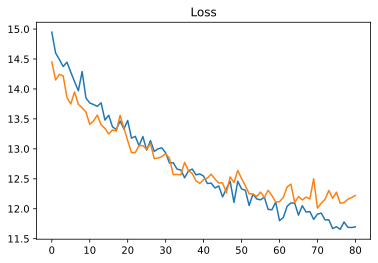

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'][40:], label='train')
plt.plot(history.history['val_MAPE'][40:], label='test')
plt.show();

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001) #0.01
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 11.8336 - MAPE: 11.8336
Epoch 00001: val_MAPE improved from 12.01071 to 11.99161, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 4s 351ms/step - loss: 11.8336 - MAPE: 11.8336 - val_loss: 11.9916 - val_MAPE: 11.9916
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 11.7119 - MAPE: 11.7119
Epoch 00002: val_MAPE did not improve from 11.99161
12/12 [==============================] - 3s 218ms/step - loss: 11.7119 - MAPE: 11.7119 - val_loss: 12.0646 - val_MAPE: 12.0646
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 11.7237 - MAPE: 11.7237
Epoch 00003: val_MAPE improved from 11.99161 to 11.96816, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
12/12 [==============================] - 3s 251ms/step - loss: 11.7237 - MAPE: 11.7237 

In [ ]:
model.load_weights(os.path.join(PATH,f'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_mlp_nlp_{ver}.hdf5'))

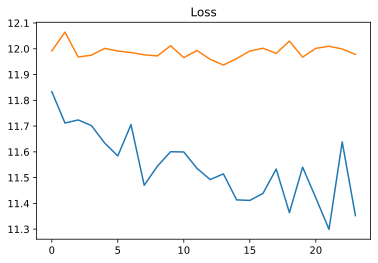

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [248]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])

print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")
print(f"TEST mape all: {(mape(y, model.predict([text_all_sequences, X])[:,0]))*100:0.2f}%")

TEST mape: 11.94%
TEST mape: 11.94%
TEST mape all: 9.55%


In [249]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
#sub_predict_nn2 = np.exp(model.predict([text_sub_sequences, X_sub]))
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn2_submission{ver}.csv'), index=False)
sub_predict_nn2

array([[ 583000.  ],
       [2719402.  ],
       [ 621290.94],
       ...,
       [1480280.2 ],
       [1098078.  ],
       [1066442.6 ]], dtype=float32)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [250]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
#for data_zip in ['img.zip']:
with zipfile.ZipFile(DATA_DIR + '/img.zip',"r") as z:    
        z.extractall(WORK_PATH)
        
print(os.listdir(WORK_PATH))

Распаковываем картинки
['__MACOSX', 'img']


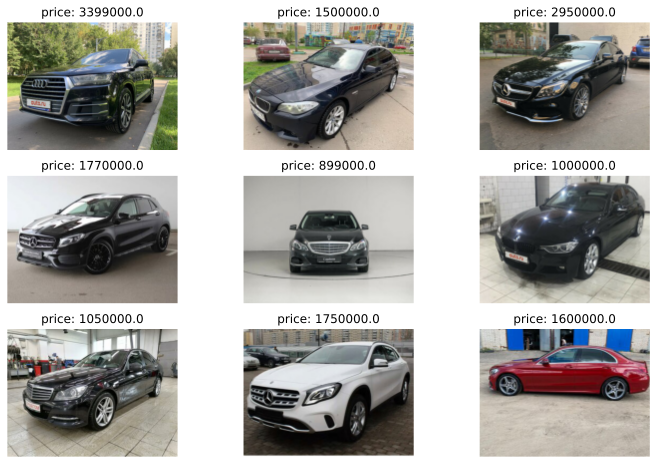

In [251]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path_ in enumerate(random_image_paths):
    im = PIL.Image.open(WORK_PATH + '/img/' + str(path_) + '.jpg')
#        im = PIL.Image.open(DATA_DIR+'/img/' + str(path_) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [252]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(WORK_PATH + '/img/' + str(sell_id) + '.jpg')
  #              image = cv2.imread(DATA_DIR + '/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

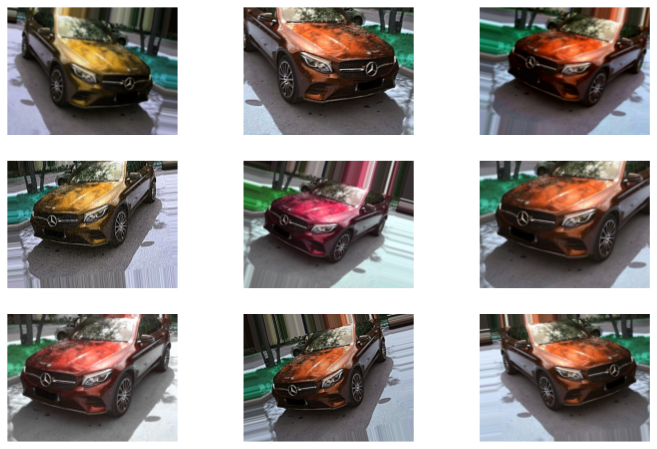

In [253]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
   # ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1), #0.1
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15,border_mode=cv2.BORDER_REPLICATE,p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
     #   IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:

# #пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
# augmentation = Compose([
#     #HorizontalFlip(),
#     #OneOf([IAAAdditiveGaussianNoise(), GaussNoise(), ], p=1),
#     #OneOf([MotionBlur(p=0.2), MedianBlur(blur_limit=3, p=0.1),Blur(blur_limit=3, p=0.1),], p=0.2),
#     #ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15,border_mode=cv2.BORDER_REPLICATE, p=1),
#    # OneOf([OpticalDistortion(p=0.3), GridDistortion(p=0.1), IAAPiecewiseAffine(p=0.3),  ], p=1),
#     OneOf([OpticalDistortion(p=0.3), GridDistortion(p=0.1),  ], p=1),
#     #OneOf([ CLAHE(clip_limit=2), IAASharpen(), IAAEmboss(),RandomBrightnessContrast(), ], p=0.3),
#     #HueSaturationValue(p=0.3),
#     ], p=1)

# #пример
# plt.figure(figsize = (12,8))
# for i in range(9):
#     img_1 = images_train[0]
#     img = augmentation(image = img_1)['image']
    
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(img)
#     plt.axis('off')
# plt.show()



In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [254]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
#tokenize.fit_on_texts(data.description)
tokenize.fit_on_texts(data.clear_description)

In [255]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.clear_description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.clear_description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.clear_description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [256]:
def tf_process_train_dataset_element_img(image,  price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image), price

def tf_process_val_dataset_element_img(image,  price):
    return (image), price

train_dataset_img = tf.data.Dataset.from_tensor_slices((
    images_train, y_train
    )).map(tf_process_train_dataset_element_img)

test_dataset_img = tf.data.Dataset.from_tensor_slices((
    images_test,  y_test
    )).map(tf_process_val_dataset_element_img)

train_dataset_img.__iter__().__next__();
test_dataset_img.__iter__().__next__();    

### Строим сверточную сеть для анализа изображений без "головы"

In [257]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3),  drop_connect_rate=0.4)                                                                
#efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [258]:
# Устанавливаем новую "голову" (head)
#efficientnet_model.training=False
efficientnet_model.trainable=False

x = efficientnet_model.output
x = L.GlobalAveragePooling2D()(x)

x = L.Dense(100, activation='relu')(x)
x = L.Dropout(0.25)(x)

predictions = L.Dense(1, )(x)

# this is the model we will train
model_img = Model(inputs=efficientnet_model.input, outputs=predictions)

In [ ]:
# # Устанавливаем новую "голову" (head)
# #efficientnet_model.training=False
# efficientnet_model.trainable=False

# x = efficientnet_model.output
# #x = L.GlobalAveragePooling2D()(x)

# x = L.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
# x = L.BatchNormalization()(x)
# x = L.Dense(256, activation='relu')(x)

# x = L.GlobalAveragePooling2D()(x)
# x = L.Dropout(0.25)(x)
# # # let's add a fully-connected layer

# x = L.Dense(100, activation='relu')(x)
# x = L.Dropout(0.25)(x)

# predictions = L.Dense(1, )(x)
# #predictions = L.Dense(1, )(efficientnet_output)
# # this is the model we will train
# model_img = Model(inputs=efficientnet_model.input, outputs=predictions)

In [260]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model_img_{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [261]:
%%time
# заморозим BatchNorm слои
# for layer in model.layers:
#         if  isinstance(layer, BatchNormalization):
#             layer.trainable  =  False 
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

#model_img.compile(loss="MAPE", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['MAPE'])
model_img.compile(loss='MAPE',optimizer=tf.keras.optimizers.Adam(0.05), metrics=['MAPE']) #0.005


history =    model_img.fit(
        train_dataset_img.batch(30),
        epochs=10,
        validation_data = test_dataset_img.batch(30),
        callbacks = callbacks_list
       )
    


In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
#model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_{ver}.hdf5'))
#model_img.save(os.path.join(PATH,'working',f'nn_img{ver}.hdf5'))

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'][12:], label='train')
plt.plot(history.history['val_MAPE'][12:], label='test')
plt.show();

In [ ]:
test_predict_img = model_img.predict(test_dataset.batch(30))
#test_predict_img = np.exp(test_predict_img[:,0]).round(-3) 
#print(f"TEST mape: {(mape(y_test_true, test_predict_img))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_img[:,0]))*100:0.2f}%")

In [263]:
# Загрузим ранее вычисленные веса
model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_55.hdf5'))
#model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_18.hdf5'))

In [264]:
test_predict_img = model_img.predict(test_dataset.batch(30))

print(f"TEST mape: {(mape(y_test, test_predict_img[:,0]))*100:0.2f}%")

TEST mape: 26.06%


In [265]:
#Разморозим всю сетку
#ver =21
efficientnet_model.trainable=True
efficientnet_model.training=False
# for layer in model_img.layers:
#         if  isinstance(layer, L.BatchNormalization):
#             layer.trainable  =  False 

model_img.compile(loss='MAPE',optimizer=tf.keras.optimizers.Adam(0.05), metrics=['MAPE'])

In [266]:
#efficientnet_output = model_img.output 

In [268]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [269]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [270]:
#объединяем выходы трех нейросетей
#combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])
combinedInput = L.concatenate([model_img.output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.25)(head) #0.25
head = L.Dense(128, activation="relu")(head)#
head = L.Dropout(0.25)(head) #
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [271]:
optimizer = tf.keras.optimizers.Adam(0.005) #0.005
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [272]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 53.5436 - MAPE: 53.5436
Epoch 00001: val_MAPE improved from inf to 45.58412, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
190/190 [==============================] - 123s 646ms/step - loss: 53.5436 - MAPE: 53.5436 - val_loss: 45.5841 - val_MAPE: 45.5841
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 35.5524 - MAPE: 35.5524
Epoch 00002: val_MAPE improved from 45.58412 to 27.31621, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model240.hdf5
190/190 [==============================] - 120s 633ms/step - loss: 35.5524 - MAPE: 35.5524 - val_loss: 27.3162 - val_MAPE: 27.3162
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 29.4336 - MAPE: 29.4336
Epoch 00003: val_MAPE improved from 27.31621 to 21.95506, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Bat

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'][12:], label='train')
plt.plot(history.history['val_MAPE'][12:], label='test')
plt.show();

In [ ]:
#model.load_weights(os.path.join(PATH,'working',f'best_model0.hdf5'))

In [ ]:
model.load_weights(os.path.join(PATH,'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_final{ver}.hdf5'))

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))

#print(f"TEST mape: {(mape(y_test_true, test_predict_nn3))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn3_submission_{ver}.csv'), index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, blend_predict.round(-3)))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2

sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission{ver}.csv'), index=False)
sample_submission['price']

In [ ]:
sub_predict_nn3[:,0], test_predict_catboost

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Input
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_modelb{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights(os.path.join(PATH,'working',f'best_modelb{ver}.hdf5'))
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
# Пробуем различные варианты бленда 
blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn1[:,0]) / 3
print(f"TEST mape with nn1: {(mape(y_test, blend_predict))*100:0.2f}%")

blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn_bonus[:,0]) / 3
print(f"TEST mape with bonus: {(mape(y_test, blend_predict))*100:0.2f}%")

blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn1[:,0]+ test_predict_nn1[:,0]) / 4
print(f"TEST mape with nn1, nn2: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
sub_predict_nn_bonus = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = sub_predict_nn_bonus[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn_bonus_submission_{ver}.csv'), index=False)

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0] + sub_predict_nn_bonus[:,0]) / 3

sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_bonus{ver}.csv'), index=False)

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0] + sub_predict_nn1[:,0]) / 3

sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_nn1{ver}.csv'), index=False)

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0] + sub_predict_nn1[:,0] + sub_predict_nn2[:,0]) / 4

sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_nn2{ver}.csv'), index=False)

In [ ]:
# Выберем предсказания лучших моделей из разных версий
ver =ver*10
df_nn3 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn3_submission_10.csv')))['price']
df_cat =  pd.read_csv(os.path.join(PATH,'submission',f'catboost_submission11.csv'))['price']
df_nn1 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn1_submission_11.csv')))['price']
df_nn2 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn2_submission16.csv')))['price']

In [ ]:
blend_sub_predict = (df_cat + df_nn3 + df_nn1) / 3
#blend_sub_predict = (df_cat + df_nn3 + df_nn1 + df_nn2) / 4

sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_nn0{ver}.csv'), index=False)

In [ ]:
sample_submission